<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/Lstm_Predictive_maintenance_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM


##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [90]:
df = pd.read_excel("/content/drive/MyDrive/Datasets/predictive maintance /AnalizDataPM.xlsx",engine='openpyxl')
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()

,Time,vibx,vibz,temp,zacc,crest,zfreq
0,2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044
1,2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983
2,2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978
3,2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902


In [91]:

df=pd.read_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
df=df.iloc[:,1:]
df

,Time,vibx,vibz,temp,zacc,crest,zfreq
0,2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044
1,2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983
2,2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978
3,2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902
...,...,...,...,...,...,...,...
395,2020-02-02 14:00:00,0.165436,0.155614,16.767343,0.092335,8.327532,0.010000
396,2020-02-02 15:00:00,0.203813,0.173919,16.581073,0.103380,8.316859,0.011656
397,2020-02-02 16:00:00,2.264839,1.148385,20.762806,0.550969,4.669187,0.117801
398,2020-02-02 17:00:00,1.853924,0.940645,26.438105,0.378305,3.659111,0.103263


In [92]:
fail_time =df[df["Time"]=="2020-01-27 14:00:00"].index[0]

In [93]:
df["rul"]=[fail_time-i for i in df.index]

In [94]:
df

,Time,vibx,vibz,temp,zacc,crest,zfreq,rul
0,2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044,254
1,2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983,253
2,2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978,252
3,2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006,251
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902,250
...,...,...,...,...,...,...,...,...
395,2020-02-02 14:00:00,0.165436,0.155614,16.767343,0.092335,8.327532,0.010000,-141
396,2020-02-02 15:00:00,0.203813,0.173919,16.581073,0.103380,8.316859,0.011656,-142
397,2020-02-02 16:00:00,2.264839,1.148385,20.762806,0.550969,4.669187,0.117801,-143
398,2020-02-02 17:00:00,1.853924,0.940645,26.438105,0.378305,3.659111,0.103263,-144


In [95]:

df['Hour'] = df['Time'].apply(lambda time: time.hour)
df['Month'] = df['Time'].apply(lambda time: time.month)
df['Day of Week'] = df['Time'].apply(lambda time: time.dayofweek)
df['Year'] = df['Time'].apply(lambda t: t.year)
df=pd.get_dummies(df,columns=['Hour','Month','Day of Week','Year'],drop_first=True)

for col in df.columns[1:7]:
  for i in range(1,4):
      df['lag_'+str(i)+col] = df[col].shift(i)
for col in df.columns[1:7]:
  df[col+'expanding_mean'] = df[col].expanding(5).mean()
  df[col+'expanding_std'] = df[col].expanding(5).std()
df.dropna(axis=0,inplace=True)

In [96]:
train_df=df[df["Time"]<="2020-01-27 14:00:00"]
test_df = df[df["Time"]>"2020-01-27 16:00:00"]

In [97]:
w0=30
w1=12
train_df["label1"]=np.where(train_df["rul"]< w0,1,0)
test_df["label1"]=np.where(test_df["rul"]< 0,0,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [98]:
train_df["label2"]=np.where(train_df["rul"]< w1,1,0)
test_df["label2"]=np.where(test_df["rul"]<0,0,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [99]:
train_df

,Time,vibx,vibz,temp,zacc,crest,zfreq,rul,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Month_2,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Day of Week_5,Day of Week_6,lag_1vibx,lag_2vibx,lag_3vibx,lag_1vibz,lag_2vibz,lag_3vibz,lag_1temp,lag_2temp,lag_3temp,lag_1zacc,lag_2zacc,lag_3zacc,lag_1crest,lag_2crest,lag_3crest,lag_1zfreq,lag_2zfreq,lag_3zfreq,vibxexpanding_mean,vibxexpanding_std,vibzexpanding_mean,vibzexpanding_std,tempexpanding_mean,tempexpanding_std,zaccexpanding_mean,zaccexpanding_std,crestexpanding_mean,crestexpanding_std,zfreqexpanding_mean,zfreqexpanding_std,label1,label2
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902,250,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.191830,1.161203,1.173835,0.957197,0.959516,1.045636,29.630256,29.187751,29.352279,0.260562,0.259026,0.262390,3.833699,3.811876,3.857893,0.070006,0.069978,0.069983,1.152533,0.072205,0.958333,0.065713,29.567965,0.373815,0.254802,0.013082,3.896978,0.150354,0.068183,0.004070,0,0
5,2020-01-17 05:00:00,1.196981,1.005627,29.738245,0.269331,3.882535,0.070050,249,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.027394,1.191830,1.161203,0.860651,0.957197,0.959516,30.167650,29.630256,29.187751,0.231498,0.260562,0.259026,4.164031,3.833699,3.811876,0.060902,0.070006,0.069978,1.159941,0.067083,0.966215,0.061866,29.596345,0.341501,0.257223,0.013118,3.894571,0.134610,0.068494,0.003719,0,0
6,2020-01-17 06:00:00,1.171047,0.990568,29.656682,0.261514,3.794298,0.070084,248,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.196981,1.027394,1.191830,1.005627,0.860651,0.957197,29.738245,30.167650,29.630256,0.269331,0.231498,0.260562,3.882535,4.164031,3.833699,0.070050,0.060902,0.070006,1.161528,0.061382,0.969694,0.057221,29.604965,0.312579,0.257836,0.012085,3.880246,0.128593,0.068721,0.003448,0,0
7,2020-01-17 07:00:00,1.140111,0.909377,29.691625,0.259911,3.936817,0.068737,247,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.171047,1.196981,1.027394,0.990568,1.005627,0.860651,29.656682,29.738245,30.167650,0.261514,0.269331,0.231498,3.794298,3.882535,4.164031,0.070084,0.070050,0.060902,1.158851,0.057331,0.962155,0.057107,29.615797,0.291010,0.258096,0.011212,3.887318,0.120723,0.068723,0.003192,0,0
8,2020-01-17 08:00:00,1.141402,0.918849,29.867964,0.258893,3.784438,0.070050,246,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.140111,1.171047,1.196981,0.909377,0.990568,1.005627,29.691625,29.656682,29.738245,0.259911,0.261514,0.269331,3.936817,3.794298,3.882535,0.068737,0.070084,0.070050,1.156912,0.053943,0.957343,0.055335,29.643816,0.284897,0.258184,0.010492,3.875887,0.118018,0.068870,0.003019,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2020-01-27 10:00:00,2.052596,0.917065,29.818260,0.413346,3.424575,0.120128,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.062732,2.036494,1.940106,0.903200,1.012302,0.888494,29.362855,30.215552,30.307087,0.414891,0.410056,0.372757,3.413356,3.408863,3.391807,0.120362,0.120089,0.110517,0.998388,0.398382,0.876566,0.376877,26.736325,4.059303,0.239473,0.085823,4.571846,1.586496,0.060785,0.024747,1,1
251,2020-01-27 11:00:00,2.041751,0.927693,30.907310,0.412740,3.471078,0.119944,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.052596,2.062732,2.036494,0.917065,0.903200,1.012302,29.818260,29.362855,30.215552,0.413346,0.414891,0.410056,3.424575,3.413356,3.408863,0.120128,0.120362,0.120089,1.002528,0.402983,0.876769,0.376139,26.752876,4.059720,0.240160,0.086345,4.567478,1.584850,0.061020,0.024977,1,1
252,2020-01-27 12:00:00,1.715945,0.695795,31.173

In [100]:
# MinMax normalization (from 0 to 1)

cols_normalize = train_df.columns.difference(['Time','rul',"label2","label1"])
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#Test


norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [101]:
train_df

,Time,vibx,vibz,temp,zacc,crest,zfreq,rul,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Month_2,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Day of Week_5,Day of Week_6,lag_1vibx,lag_2vibx,lag_3vibx,lag_1vibz,lag_2vibz,lag_3vibz,lag_1temp,lag_2temp,lag_3temp,lag_1zacc,lag_2zacc,lag_3zacc,lag_1crest,lag_2crest,lag_3crest,lag_1zfreq,lag_2zfreq,lag_3zfreq,vibxexpanding_mean,vibxexpanding_std,vibzexpanding_mean,vibzexpanding_std,tempexpanding_mean,tempexpanding_std,zaccexpanding_mean,zaccexpanding_std,crestexpanding_mean,crestexpanding_std,zfreqexpanding_mean,zfreqexpanding_std,label1,label2
4,2020-01-17 04:00:00,0.408137,0.251231,0.757928,0.276698,0.103320,0.312238,250,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.483095,0.469133,0.474892,0.284592,0.285393,0.315152,0.732471,0.711508,0.719302,0.319974,0.317686,0.322696,0.059123,0.056204,0.062360,0.367950,0.367780,0.367814,0.905524,0.085864,0.931224,0.066311,0.933664,0.026591,0.887009,0.050147,0.059828,0.043254,0.918507,0.069939,0,0
5,2020-01-17 05:00:00,0.485443,0.301327,0.737586,0.333032,0.065657,0.368223,249,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.408137,0.483095,0.469133,0.251231,0.284592,0.285393,0.757928,0.732471,0.711508,0.276698,0.319974,0.317686,0.103320,0.059123,0.056204,0.312238,0.367950,0.367780,0.939190,0.072266,0.978940,0.054898,0.941998,0.018184,0.956826,0.050615,0.057000,0.033386,0.944417,0.054689,0,0
6,2020-01-17 06:00:00,0.473621,0.296123,0.733723,0.321392,0.053852,0.368428,248,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.485443,0.408137,0.483095,0.301327,0.251231,0.284592,0.737586,0.757928,0.732471,0.333032,0.276698,0.319974,0.065657,0.103320,0.059123,0.368223,0.312238,0.367950,0.946401,0.057131,1.000000,0.041120,0.944529,0.010659,0.974499,0.037389,0.040169,0.029615,0.963321,0.042891,0,0
7,2020-01-17 07:00:00,0.459519,0.268068,0.735378,0.319005,0.072920,0.360186,247,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.473621,0.485443,0.408137,0.296123,0.301327,0.251231,0.733723,0.737586,0.757928,0.321392,0.333032,0.276698,0.053852,0.065657,0.103320,0.368428,0.368223,0.312238,0.934234,0.046377,0.954358,0.040783,0.947710,0.005047,0.981975,0.026226,0.048477,0.024682,0.963486,0.031770,0,0
8,2020-01-17 08:00:00,0.460107,0.271341,0.743732,0.317489,0.052532,0.368223,246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.459519,0.473621,0.485443,0.268068,0.296123,0.301327,0.735378,0.733723,0.737586,0.319005,0.321392,0.333032,0.072920,0.053852,0.065657,0.360186,0.368428,0.368223,0.925423,0.037382,0.925230,0.035526,0.955937,0.003457,0.984530,0.017003,0.035047,0.022987,0.975761,0.024222,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2020-01-27 10:00:00,0.875471,0.270724,0.741377,0.547470,0.004384,0.674694,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.880092,0.868131,0.824193,0.265933,0.303633,0.260852,0.719803,0.760198,0.764534,0.549771,0.542570,0.487033,0.002883,0.002282,0.000000,0.676125,0.674457,0.615876,0.204977,0.951754,0.436246,0.989299,0.102152,0.985441,0.445059,0.980894,0.852752,0.943384,0.302688,0.969033,1,1
251,2020-01-27 11:00:00,0.870527,0.274397,0.792968,0.546568,0.010606,0.673571,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0

In [102]:
test_df

,Time,vibx,vibz,temp,zacc,crest,zfreq,rul,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Month_2,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Day of Week_5,Day of Week_6,lag_1vibx,lag_2vibx,lag_3vibx,lag_1vibz,lag_2vibz,lag_3vibz,lag_1temp,lag_2temp,lag_3temp,lag_1zacc,lag_2zacc,lag_3zacc,lag_1crest,lag_2crest,lag_3crest,lag_1zfreq,lag_2zfreq,lag_3zfreq,vibxexpanding_mean,vibxexpanding_std,vibzexpanding_mean,vibzexpanding_std,tempexpanding_mean,tempexpanding_std,zaccexpanding_mean,zaccexpanding_std,crestexpanding_mean,crestexpanding_std,zfreqexpanding_mean,zfreqexpanding_std,label1,label2
0,2020-01-27 17:00:00,0.929025,0.285568,0.710455,0.551171,0.005625,0.675785,-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.916203,0.920649,0.937059,0.291659,0.262588,0.271492,0.714689,0.712779,0.714375,0.546046,0.543988,0.545732,0.004043,0.003903,0.004986,0.674388,0.674218,0.674185,0.339231,1.040576,0.440276,0.974866,0.126023,0.979265,0.571135,1.018119,0.820371,0.935693,0.428608,1.026960,0,0
1,2020-01-27 18:00:00,0.915819,0.285907,0.720390,0.558555,0.004397,0.682674,-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.929025,0.916203,0.920649,0.285568,0.291659,0.262588,0.710455,0.714689,0.712779,0.551171,0.546046,0.543988,0.005625,0.004043,0.003903,0.675785,0.674388,0.674218,0.358764,1.052993,0.442234,0.972833,0.128923,0.978044,0.590832,1.024616,0.815292,0.934744,0.447614,1.035982,0,0
2,2020-01-27 19:00:00,0.918672,0.284766,0.691048,0.547760,0.007168,0.672549,-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.915819,0.929025,0.916203,0.285907,0.285568,0.291659,0.720390,0.710455,0.714689,0.558555,0.551171,0.546046,0.004397,0.005625,0.004043,0.682674,0.675785,0.674388,0.378256,1.065235,0.444100,0.970804,0.131101,0.976480,0.609573,1.030274,0.810346,0.933759,0.465944,1.044173,0,0
3,2020-01-27 20:00:00,0.758064,0.240931,0.681038,0.442467,0.188509,0.509522,-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.918672,0.915819,0.929025,0.284766,0.285907,0.285568,0.691048,0.720390,0.710455,0.547760,0.558555,0.551171,0.007168,0.004397,0.005625,0.672549,0.682674,0.675785,0.391464,1.069607,0.443010,0.968721,0.133024,0.974827,0.620359,1.030673,0.811539,0.931917,0.475637,1.044865,0,0
4,2020-01-27 21:00:00,0.955175,0.266484,0.611448,0.523618,0.017449,0.622901,-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.758064,0.918672,0.915819,0.240931,0.284766,0.285907,0.681038,0.691048,0.720390,0.442467,0.547760,0.558555,0.188509,0.007168,0.004397,0.509522,0.672549,0.682674,0.412072,1.083423,0.443636,0.966628,0.133287,0.972829,0.637061,1.034737,0.806989,0.930818,0.491143,1.050107,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,2020-02-02 14:00:00,0.015218,0.007606,0.123121,0.069484,0.660379,0.000722,-141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.013168,0.013175,0.012481,0.006709,0.006686,0.007175,0.153443,0.173082,0.208821,0.071992,0.071421,0.072513,0.650473,0.643383,0.670130,0.000960,0.000824,0.000722,1.388658,1.487352,0.334531,0.886799,0.092429,0.906903,1.670955,1.258396,0.779928,0.981878,1.377765,1.332673,0,0
139,2020-02-02 15:00:00,0.032712,0.013931,0.114297,0.085930,0.658951,0.010860,-142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [103]:
# pick  window size 
sequence_length = 10

# function to reshape features into (samples, time steps, features)

def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sequence_cols=train_df.columns.difference(['Time','rul',"label2","label1"])

# generator for the sequences
#seq_gen=(list(gen_sequence(train_df[train_df.index==id], sequence_length, sequence_cols))  for id in train_df.index)
seq_gen = list(list(gen_sequence(train_df, sequence_length, sequence_cols)))
           

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
seq_array=np.reshape(seq_array, (len(seq_gen),sequence_length,len(sequence_cols)))
print(seq_array.shape)


(241, 10, 66)


In [104]:
train_df

,Time,vibx,vibz,temp,zacc,crest,zfreq,rul,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Month_2,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Day of Week_5,Day of Week_6,lag_1vibx,lag_2vibx,lag_3vibx,lag_1vibz,lag_2vibz,lag_3vibz,lag_1temp,lag_2temp,lag_3temp,lag_1zacc,lag_2zacc,lag_3zacc,lag_1crest,lag_2crest,lag_3crest,lag_1zfreq,lag_2zfreq,lag_3zfreq,vibxexpanding_mean,vibxexpanding_std,vibzexpanding_mean,vibzexpanding_std,tempexpanding_mean,tempexpanding_std,zaccexpanding_mean,zaccexpanding_std,crestexpanding_mean,crestexpanding_std,zfreqexpanding_mean,zfreqexpanding_std,label1,label2
4,2020-01-17 04:00:00,0.408137,0.251231,0.757928,0.276698,0.103320,0.312238,250,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.483095,0.469133,0.474892,0.284592,0.285393,0.315152,0.732471,0.711508,0.719302,0.319974,0.317686,0.322696,0.059123,0.056204,0.062360,0.367950,0.367780,0.367814,0.905524,0.085864,0.931224,0.066311,0.933664,0.026591,0.887009,0.050147,0.059828,0.043254,0.918507,0.069939,0,0
5,2020-01-17 05:00:00,0.485443,0.301327,0.737586,0.333032,0.065657,0.368223,249,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.408137,0.483095,0.469133,0.251231,0.284592,0.285393,0.757928,0.732471,0.711508,0.276698,0.319974,0.317686,0.103320,0.059123,0.056204,0.312238,0.367950,0.367780,0.939190,0.072266,0.978940,0.054898,0.941998,0.018184,0.956826,0.050615,0.057000,0.033386,0.944417,0.054689,0,0
6,2020-01-17 06:00:00,0.473621,0.296123,0.733723,0.321392,0.053852,0.368428,248,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.485443,0.408137,0.483095,0.301327,0.251231,0.284592,0.737586,0.757928,0.732471,0.333032,0.276698,0.319974,0.065657,0.103320,0.059123,0.368223,0.312238,0.367950,0.946401,0.057131,1.000000,0.041120,0.944529,0.010659,0.974499,0.037389,0.040169,0.029615,0.963321,0.042891,0,0
7,2020-01-17 07:00:00,0.459519,0.268068,0.735378,0.319005,0.072920,0.360186,247,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.473621,0.485443,0.408137,0.296123,0.301327,0.251231,0.733723,0.737586,0.757928,0.321392,0.333032,0.276698,0.053852,0.065657,0.103320,0.368428,0.368223,0.312238,0.934234,0.046377,0.954358,0.040783,0.947710,0.005047,0.981975,0.026226,0.048477,0.024682,0.963486,0.031770,0,0
8,2020-01-17 08:00:00,0.460107,0.271341,0.743732,0.317489,0.052532,0.368223,246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.459519,0.473621,0.485443,0.268068,0.296123,0.301327,0.735378,0.733723,0.737586,0.319005,0.321392,0.333032,0.072920,0.053852,0.065657,0.360186,0.368428,0.368223,0.925423,0.037382,0.925230,0.035526,0.955937,0.003457,0.984530,0.017003,0.035047,0.022987,0.975761,0.024222,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2020-01-27 10:00:00,0.875471,0.270724,0.741377,0.547470,0.004384,0.674694,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.880092,0.868131,0.824193,0.265933,0.303633,0.260852,0.719803,0.760198,0.764534,0.549771,0.542570,0.487033,0.002883,0.002282,0.000000,0.676125,0.674457,0.615876,0.204977,0.951754,0.436246,0.989299,0.102152,0.985441,0.445059,0.980894,0.852752,0.943384,0.302688,0.969033,1,1
251,2020-01-27 11:00:00,0.870527,0.274397,0.792968,0.546568,0.010606,0.673571,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0

In [105]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df, sequence_length, ['label1'])]
label_array = np.concatenate(label_gen).astype(np.float32)
print(label_array.shape)

(241, 1)


In [106]:
model_path = 'classification_model.h5'

In [107]:
# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=200, batch_size=3, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=50, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 100)           66800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 97,051
Trainable params: 97,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
72/72 - 4s - loss: 0.1148 - accuracy: 0.9676 - val_loss: 4.6515 - val_accuracy: 0.0000e+00
Epoch 2/

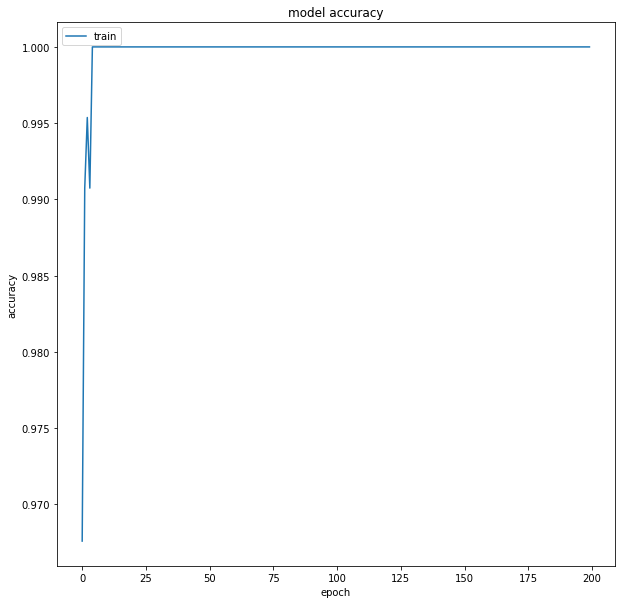

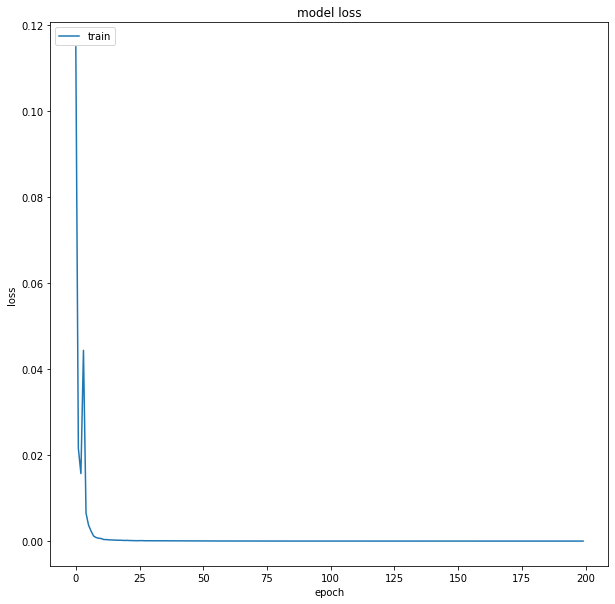

2/2 [==============================] - 0s 11ms/step - loss: 1.1109 - accuracy: 0.9336
Accurracy: 0.9336099624633789


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 10ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[211   0]
 [ 16  14]]
Precision: [0.92951542 1.        ]
recall =  [1.         0.46666667]


In [108]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
print("Precision:",precision_score(y_true, y_pred, average=None)) 
recall = recall_score(y_true, y_pred, average=None)
print(  'recall = ', recall)

In [109]:
# pick the feature columns 
sequence_cols=train_df.columns.difference(['Time','rul',"label2","label1"])

# generator for the sequences

seq_gen = list(list(gen_sequence(test_df, sequence_length, sequence_cols)))
           

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
seq_array_test_last=np.reshape(seq_array, (len(seq_gen),sequence_length,len(sequence_cols)))
print(seq_array_test_last.shape) 

(133, 10, 66)


In [110]:
# generate labels
label_gen = [gen_labels(test_df, sequence_length, ['label1'])]
label_array_test_last = np.concatenate(label_gen).astype(np.float32)
print(label_array_test_last.shape)

(133, 1)


5/5 - 1s - loss: 0.5144 - accuracy: 0.9624
Accurracy: 0.9624060392379761


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[128   5]
 [  0   0]]
Precision:  0.0 
 Recall:  0.0 
 F1-score: nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


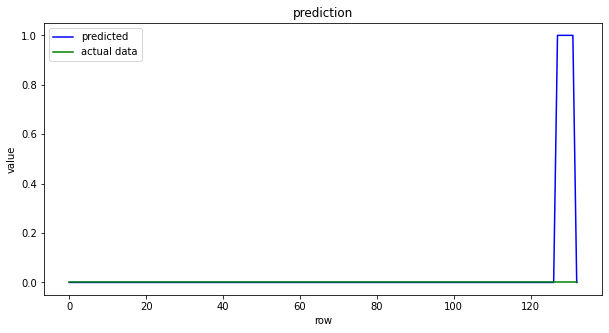

In [111]:

import os
# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)
# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = estimator.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")